In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

In [2]:
from sklearn import metrics

In [4]:
df_train = pd.read_csv('train.csv', sep=',')
print(df_train.shape) # 4 151 496
print(df_train.drop_duplicates().shape)
df_train.head()

(4151496, 2)
(4151496, 2)


,Password,Times
0,631XniVx2lS5I,2
1,LEGIT747,1
2,742364es,1
3,3846696477,1
4,laurahop,2


In [5]:
df_train[df_train.Password.isnull()].head()

,Password,Times
66233,NaN,27
157331,NaN,3


In [7]:
df_train.loc[[66233, 157331], 'Password'] = df_train.loc[[66233, 157331], 'Password'].astype(str)

In [8]:
df_train['length'] = df_train.Password.apply(lambda x: len(str(x)))
df_train.head()

,Password,Times,length
0,631XniVx2lS5I,2,13
1,LEGIT747,1,8
2,742364es,1,8
3,3846696477,1,10
4,laurahop,2,8


#### Фичи сколько гласных, согласных 

In [10]:
delete_symbols = ['1', '2', '3', '4', '5', '6', '7', '8', '9','0','!','.','~', '/', ';', ':', '\\', '&','^','*', '(',')','%','$','#','@','>','<','?']
numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
symbols = ['!','.','~', '/', ';', ':', '\\', '&','^','*', '(',')','%','$','#','@','>','<','?']

glasnye = ['a', 'e', 'u', 'o', 'y', 'i']
soglasnye = ['q','w','s', 'x', 'z', 'r', 'f', 'd','c','v', 't','g','h','b','n','j','k','m','l', 'p']

In [11]:
df_train['cnt_chars'] = df_train.Password.apply(lambda x: sum([1 for char in str(x) if char not in delete_symbols]))
df_train['cnt_numbers'] = df_train.Password.apply(lambda x: sum([1 for char in str(x) if char in numbers]))
df_train['cnt_symbolss'] = df_train.Password.apply(lambda x: sum([1 for char in str(x) if char in symbols]))

df_train['cnt_glasnye'] = df_train.Password.apply(lambda x: sum([1 for char in str(x) if char in glasnye]))
df_train['cnt_soglasnye'] = df_train.Password.apply(lambda x: sum([1 for char in str(x) if char in soglasnye]))
df_train.head()

,Password,Times,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye
0,631XniVx2lS5I,2,13,8,5,0,1,3
1,LEGIT747,1,8,5,3,0,0,0
2,742364es,1,8,2,6,0,1,1
3,3846696477,1,10,0,10,0,0,0
4,laurahop,2,8,8,0,0,4,4


#### Разобьем на трейн и валидацию рандомно

In [12]:
lst_indexes = df_train.index.tolist()
print(len(lst_indexes))

4151496


In [13]:
np.random.seed(0)
lst_inds_to_tr = np.random.choice(lst_indexes, size=1245450, replace=False)
print(len(lst_inds_to_tr)) # 1 245 450

1245450


In [14]:
df_train_tr = df_train.loc[lst_inds_to_tr, :]
df_train_val = df_train.drop(lst_inds_to_tr)
print(df_train_tr.shape)
print(df_train_val.shape)
print(df_train.shape)
df_train_val.head(2)

(1245450, 8)
(2906046, 8)
(4151496, 8)


,Password,Times,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye
0,631XniVx2lS5I,2,13,8,5,0,1,3
3,3846696477,1,10,0,10,0,0,0


## Попробуем tf-idf

In [15]:
from xgboost import XGBRegressor, XGBClassifier

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [16]:
df_train_tr[df_train_tr.Password.isnull()].head()

,Password,Times,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye


In [17]:
df_train_tr.loc[[66233], 'Password'] = df_train_tr.loc[[66233], 'Password'].astype(str)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_df=0.8, min_df=0.05) # , min_df=0.05
tfidf_vectorizer.fit(df_train_tr.Password)
values_tr = tfidf_vectorizer.transform(df_train_tr.Password)

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
df_train_tr_tfidf = pd.DataFrame(values_tr.toarray(), columns=feature_names)
print(df_train_tr_tfidf.shape)
df_train_tr_tfidf.head(2)

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(1245450, 39)


,0,1,12,19,2,3,4,5,6,7,...,p,r,s,t,u,v,w,x,y,z
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.326168,0.0,0.389757,0.446100,0.0,0.0,0.0,0.0
1,0.0,0.356976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.399624,0.0,0.000000,0.546565,0.0,0.0,0.0,0.0


In [29]:
df_train_tr = df_train_tr.reset_index().drop(['index'], axis=1).reset_index()
df_train_tr_tfidf = df_train_tr_tfidf.reset_index()

df_train_tr_all2 = df_train_tr.merge(df_train_tr_tfidf, on=['index'], how='inner')
print(df_train_tr_all2.shape) # (1245450, 273)  # (1245450, 41)
#df_train_tr_all2.head(2)

(1245450, 48)


In [30]:
import math
df_train_tr_all2['target_mod'] = df_train_tr_all2.Times.apply(lambda x: math.log(x + 1))
ftarget = 'target_mod'
all_features = df_train_tr_all2.columns[4:-1]

In [31]:
%%time
xgb_regr2 = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, nthread=40)
xgb_regr2.fit(df_train_tr_all2[all_features], df_train_tr_all2[ftarget])

CPU times: user 29min 18s, sys: 6.81 s, total: 29min 25s
Wall time: 1min 11s


In [22]:
df_train_val[df_train_val.Password.isnull()].head()

,Password,Times,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye


In [23]:
df_train_val.loc[[157331], 'Password'] = df_train_val.loc[[157331], 'Password'].astype(str)

In [32]:
tfidf_val = tfidf_vectorizer.transform(df_train_val.Password)

# Show the Bag-of-Words Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
df_train_val_tfidf = pd.DataFrame(tfidf_val.toarray(), columns=feature_names)

print(df_train_val_tfidf.shape)
df_train_val_tfidf.columns[:100]

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(2906046, 39)


Index(['0', '1', '12', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'an',
       'b', 'c', 'd', 'e', 'er', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='object')

In [25]:
del tfidf_val, 

In [33]:
#df_train_val = df_train_val.reset_index().drop(['index'], axis=1).reset_index()
df_train_val_tfidf = df_train_val_tfidf.reset_index()

df_train_val_all2 = df_train_val.merge(df_train_val_tfidf, on=['index'], how='inner')
print(df_train_val_all2.shape)
#df_train_val_all2.head(2)

(2906046, 48)


In [ ]:
all_features[:10]

In [34]:
df_train_val_all2['target_mod'] = df_train_val_all2.Times.apply(lambda x: math.log(x + 1))
df_train_val_all2['preds'] = xgb_regr2.predict(df_train_val_all2[all_features])
import math
math.sqrt(metrics.mean_squared_error(df_train_val_all2[ftarget], df_train_val_all2.preds)) 

0.3764018155874843

### Обучим на всём трейне, разметим тестовые данные и засабмитим

In [35]:
df_train[df_train.Password.isnull()].head()

,Password,Times,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye


In [36]:
df_train.loc[[66233, 157331], 'Password'] = df_train.loc[[66233, 157331], 'Password'].astype(str)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_df=0.8, min_df=0.05)
tfidf_vectorizer.fit(df_train.Password)
values_tr = tfidf_vectorizer.transform(df_train.Password)

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
df_train_tfidf = pd.DataFrame(values_tr.toarray(), columns=feature_names)
print(df_train_tfidf.shape)
df_train_tfidf.head(2)

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(4151496, 39)


,0,1,12,19,2,3,4,5,6,7,...,p,r,s,t,u,v,w,x,y,z
0,0.0,0.181071,0.0,0.0,0.198326,0.220554,0.000000,0.227793,0.232535,0.000000,...,0.0,0.0,0.202414,0.000000,0.0,0.277501,0.0,0.644812,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.327494,0.000000,0.000000,0.657729,...,0.0,0.0,0.000000,0.303321,0.0,0.000000,0.0,0.000000,0.0,0.0


In [38]:
df_train = df_train.reset_index().drop(['index'], axis=1).reset_index()
df_train_tfidf = df_train_tfidf.reset_index()

df_train_all = df_train.merge(df_train_tfidf, on=['index'], how='inner')
print(df_train_all.shape)
df_train_all.head(2)

(4151496, 48)


,index,Password,Times,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye,0,...,p,r,s,t,u,v,w,x,y,z
0,0,631XniVx2lS5I,2,13,8,5,0,1,3,0.0,...,0.0,0.0,0.202414,0.000000,0.0,0.277501,0.0,0.644812,0.0,0.0
1,1,LEGIT747,1,8,5,3,0,0,0,0.0,...,0.0,0.0,0.000000,0.303321,0.0,0.000000,0.0,0.000000,0.0,0.0


In [39]:
del df_train_tfidf, df_train

In [40]:
import math
df_train_all['target_mod'] = df_train_all.Times.apply(lambda x: math.log(x + 1))
ftarget = 'target_mod'
all_features = df_train_all.columns[4:-1]

In [41]:
'target_mod' in all_features

False

In [42]:
%%time
xgb_regr3 = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, nthread=40)
xgb_regr3.fit(df_train_all[all_features], df_train_all[ftarget])

CPU times: user 1h 40min 50s, sys: 18.3 s, total: 1h 41min 8s
Wall time: 4min 30s


In [43]:
df_test = pd.read_csv('Xtest.csv', sep=',')
print(df_test.shape) # 1 037 875
print(df_test.drop_duplicates().shape)
df_test.head()

(1037875, 2)
(1037875, 2)


,Id,Password
0,0,ThaisCunha
1,1,697775113
2,2,922a16922a
3,3,andy74
4,4,joemack


In [44]:
df_test['length'] = df_test.Password.apply(lambda x: len(str(x)))

df_test['cnt_chars'] = df_test.Password.apply(lambda x: sum([1 for char in str(x) if char not in delete_symbols]))
df_test['cnt_numbers'] = df_test.Password.apply(lambda x: sum([1 for char in str(x) if char in numbers]))
df_test['cnt_symbolss'] = df_test.Password.apply(lambda x: sum([1 for char in str(x) if char in symbols]))

df_test['cnt_glasnye'] = df_test.Password.apply(lambda x: sum([1 for char in str(x) if char in glasnye]))
df_test['cnt_soglasnye'] = df_test.Password.apply(lambda x: sum([1 for char in str(x) if char in soglasnye]))
df_test.head()

,Id,Password,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye
0,0,ThaisCunha,10,10,0,0,4,4
1,1,697775113,9,0,9,0,0,0
2,2,922a16922a,10,2,8,0,2,0
3,3,andy74,6,4,2,0,2,2
4,4,joemack,7,7,0,0,3,4


In [45]:
df_test[df_test.Password.isnull()].head()

,Id,Password,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye
581317,581317,NaN,3,3,0,0,1,2


In [46]:
df_test.loc[[581317], 'Password'] = df_test.loc[[581317], 'Password'].astype(str)

In [47]:
tfidf_test = tfidf_vectorizer.transform(df_test.Password)

# Show the Bag-of-Words Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
df_test_tfidf = pd.DataFrame(tfidf_test.toarray(), columns=feature_names)

print(df_test_tfidf.shape)
df_test_tfidf.columns[:100]

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(1037875, 39)


Index(['0', '1', '12', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'an',
       'b', 'c', 'd', 'e', 'er', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='object')

In [48]:
df_test = df_test.reset_index()
df_test_tfidf = df_test_tfidf.reset_index()

df_test_all2 = df_test.merge(df_test_tfidf, on=['index'], how='inner')
print(df_test_all2.shape)
df_test_all2.head(2)

(1037875, 48)


,index,Id,Password,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye,0,...,p,r,s,t,u,v,w,x,y,z
0,0,0,ThaisCunha,10,10,0,0,4,4,0.0,...,0.0,0.0,0.257613,0.271172,0.308074,0.0,0.0,0.0,0.0,0.0
1,1,1,697775113,9,0,9,0,0,0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [49]:
df_test_all2 = df_test_all2.drop(['index'], axis=1)

In [50]:
df_test_all2['preds'] = xgb_regr3.predict(df_test_all2[all_features])

### Теперь этот скор надо обратно преобразовать из Log(a(x_i) + 1) в этот a(x_i)

In [51]:
df_test_all2['preds_unwrap'] = df_test_all2.preds.apply(lambda x: math.exp(x) - 1)
df_test_all2.head(2)

,Id,Password,length,cnt_chars,cnt_numbers,cnt_symbolss,cnt_glasnye,cnt_soglasnye,0,1,...,s,t,u,v,w,x,y,z,preds,preds_unwrap
0,0,ThaisCunha,10,10,0,0,4,4,0.0,0.000000,...,0.257613,0.271172,0.308074,0.0,0.0,0.0,0.0,0.0,0.760166,1.138631
1,1,697775113,9,0,9,0,0,0,0.0,0.401632,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.723570,1.061781


In [52]:
df_to_submit = df_test_all2[['Id', 'preds_unwrap']]
df_to_submit = df_to_submit.rename(columns = {'preds_unwrap': 'Times'})
df_to_submit.head()

,Id,Times
0,0,1.138631
1,1,1.061781
2,2,1.108879
3,3,1.289214
4,4,1.482255


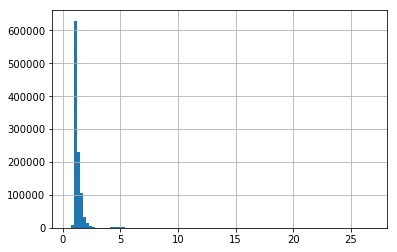

In [53]:
df_to_submit.Times.hist(bins=100)

In [ ]:
df_example.head()

In [54]:
df_to_submit.to_csv('fifth_submit_dmia_sport_on_tfidf_ngrams_xgb_5_300_005.csv', sep=',', index=False)
qq = pd.read_csv('fifth_submit_dmia_sport_on_tfidf_ngrams_xgb_5_300_005.csv', sep=',')
print(qq.shape)
qq.head()

(1037875, 2)


,Id,Times
0,0,1.138631
1,1,1.061781
2,2,1.108879
3,3,1.289214
4,4,1.482255
